In [39]:
import torchvision

from torchvision.transforms import v2
from torchvision import tv_tensors

from sklearn import model_selection
from sklearn import metrics
#from torchvision import datapoints

from prepare_numpy_data import read_video_frames_opencv

from models import Wav2vec2Extractor, SequenceAverageFeatures, Swin3d_T_extractor
from datasets import AppendZeroValues, NumpyVideoExtractorDataset

import torchaudio
import torchaudio.transforms as T
import torch
from torch import nn
import cv2
import numpy as np

import scipy
import shutil
import glob
import os

from torch.utils._pytree import tree_flatten, tree_unflatten

import pandas as pd

import time

from tqdm import tqdm

from IPython.display import Audio

from typing import Sequence
from numbers import Number

import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
metrics.recall_score([1,2,3],[0,2,3],average=None)

c:\Users\mokhail\miniconda3\envs\aggr_rec\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0., 0., 1., 1.])

# Проверка аудио

In [8]:
class TransformerSequenceProcessor(nn.Module):
    def __init__(self, extractor_model, hidden_size, transformer_layer_num, transformer_head_num, class_num):
        super().__init__()
        self.feature_extractor = extractor_model
        transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=transformer_head_num, batch_first=True)
        self.transformer_squence_processing = nn.TransformerEncoder(
            transformer_layer,
            num_layers=transformer_layer_num,
            norm=nn.LayerNorm(hidden_size))
        
        self.average_features_sequence = SequenceAverageFeatures(hidden_size=hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, class_num)
            )

    def forward(self, x):
        with torch.no_grad():
            features = self.feature_extractor(x)
        transformer_sequence_features = self.transformer_squence_processing(features)
        avg_features = self.average_features_sequence(transformer_sequence_features)
        
        classifier_out = self.classifier(avg_features)
        return classifier_out, transformer_sequence_features

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
sample_rate = bundle.sample_rate

path_to_file = r'i:\AVABOS\DATSET_V0_train_test_split\train\verbal\pt_waveform\c-0_v-0-1_F-0-0_0.65-3.17_AGGR.pt'
waveform = torch.load(path_to_file)
waveform = waveform.unsqueeze(0)

wav2vec2 = Wav2vec2Extractor(bundle.get_model())

audio_nn = TransformerSequenceProcessor(
    extractor_model=wav2vec2,
    transformer_layer_num=2,
    transformer_head_num=8,
    hidden_size=768,
    class_num=2)
out, features = audio_nn(waveform)

out.shape


torch.Size([1, 2])

In [10]:
features.shape

torch.Size([1, 125, 768])

# Проверка текста

In [14]:
text_nn = TransformerSequenceProcessor(
    extractor_model=nn.Sequential(),
    transformer_layer_num=2,
    transformer_head_num=8,
    hidden_size=768,
    class_num=2
)

path_to_file = r'i:\AVABOS\DATSET_V0_train_test_split\train\verbal\rubert_cased_L-12_H-768_A-12_pt_v1_tokens\c-0_v-0-1_F-0-0_0.65-3.17_AGGR.npy'
embeddings = torch.tensor(np.load(path_to_file))
embeddings = embeddings.unsqueeze(0)
out, features = text_nn(embeddings)
out.shape

torch.Size([1, 2])

# Проверка видео

In [15]:
import pandas as pd
import json
target_frame_num = 64
video_extractor = Swin3d_T_extractor(frame_num=target_frame_num, window_size=16)

video_nn = TransformerSequenceProcessor(
    extractor_model=video_extractor,
    transformer_layer_num=2,
    transformer_head_num=8,
    hidden_size=768,
    class_num=2)

path_to_file = r'i:\AVABOS\DATSET_V0_train_test_split\train\physical\video\c-0_v-11-2_M-30-2_6.579-7.807_AGGR.pt'
video = torch.load(path_to_file)

transforms = v2.Compose([
    v2.Resize((112, 112)),
    AppendZeroValues(target_size=[target_frame_num, 3, 112, 112]),
    v2.ToDtype(torch.float32, scale=True)
])
video = transforms(video)
video=video.permute(1,0,2,3).unsqueeze(0)
res, sequence_features = video_nn(video)
sequence_features.shape


c:\Users\mokhail\miniconda3\envs\aggr_rec\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 768])

# проверка разбиения выборки

In [73]:
path_to_intersections_csv = r'i:\AVABOS\DATSET_V0\time_intervals_combinations_table.csv'
time_interval_combinations_df = pd.read_csv(path_to_intersections_csv)
path_to_train_test_split_json = 'train_test_split.json'
with open(path_to_train_test_split_json) as fd:
    combinations_indices_dict = json.load(fd)

train_time_interval_combinations_df =  []
for cluster_id in combinations_indices_dict['train_clusters']:
    df = time_interval_combinations_df[time_interval_combinations_df['cluster_id']==cluster_id]
    train_time_interval_combinations_df.append(df)
train_time_interval_combinations_df = pd.concat(train_time_interval_combinations_df, ignore_index=True)

test_time_interval_combinations_df =  []
for cluster_id in combinations_indices_dict['test_clusters']:
    df = time_interval_combinations_df[time_interval_combinations_df['cluster_id']==cluster_id]
    test_time_interval_combinations_df.append(df)
test_time_interval_combinations_df = pd.concat(test_time_interval_combinations_df, ignore_index=True)
train_time_interval_combinations_df

,project_name,unique_person,video,person_name,gender,phys_t1,phys_t2,text,aggr_type,phys_aggr_label,video_id,person_id,cluster_id,verb_t1,verb_t2,verb_aggr_label
0,-kpsb88q2ac(+),ж в красном платье (-kp),-kpsb88q2ac(+)_._10.066-50.066,ж в красном платье (-kp),F,0,2000,NO PHRASE,phys,NOAGGR,v-0-0,F-0-0,0,-1,-1,-1
1,-kpsb88q2ac(+),ж в красном платье (-kp),-kpsb88q2ac(+)_._10.066-50.066,ж в красном платье (-kp),F,2000,4000,NO PHRASE,phys,NOAGGR,v-0-0,F-0-0,0,-1,-1,-1
2,-kpsb88q2ac(+),ж в красном платье (-kp),-kpsb88q2ac(+)_._10.066-50.066,ж в красном платье (-kp),F,4000,6000,NO PHRASE,phys,NOAGGR,v-0-0,F-0-0,0,-1,-1,-1
3,-kpsb88q2ac(+),ж в красном платье (-kp),-kpsb88q2ac(+)_._10.066-50.066,ж в красном платье (-kp),F,6000,8000,NO PHRASE,phys,NOAGGR,v-0-0,F-0-0,0,-1,-1,-1
4,-kpsb88q2ac(+),ж в красном платье (-kp),-kpsb88q2ac(+)_._10.066-50.066,ж в красном платье (-kp),F,8000,10000,NO PHRASE,phys,NOAGGR,v-0-0,F-0-0,0,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9511,UzqcLWdxBlQ(+),ж с телефоном в руках (uzq),UzqcLWdxBlQ(+)_._0.066-70.066,ж с телефоном в руках (uzq),F,-1,-1,Да блин!,verb,-1,v-54-0,F-220-0,18,17370,19090,NOAGGR
9512,UzqcLWdxBlQ(+),ж с телефоном в руках (uzq),UzqcLWdxBlQ(+)_._0.066-70.066,ж с телефоном в руках (uzq),F,-1,-1,Ой!,verb,-1,v-54-0,F-220-0,18,44558,45679,NOAGGR
9513,UzqcLWdxBlQ(+),ж с телефоном в руках (uzq),UzqcLWdxBlQ(+)_._0.066-70.066,ж с телефоном в руках (uzq),F,-1,-1,Да блин!,verb,-1,v-54-0,F-220-0,18,46595,47359,NOAGGR
9514,UzqcLWdxBlQ(+),ж с телефоном в руках (uzq),UzqcLWdxBlQ(+)_._0.066-70.066,ж с телефоном в руках (uzq),F,-1,-1,"Ну ладно, пойдемте!",verb,-1,v-54-0,F-220-0,18,51010,53350,NOAGGR


In [88]:
import random
batch_size = 8
batch_indices_list = []
for aggr_type in train_time_interval_combinations_df['aggr_type'].unique():
    aggr_type_indices = train_time_interval_combinations_df[train_time_interval_combinations_df['aggr_type']==aggr_type].index.tolist()
    # перемешиваем индексы
    random.shuffle(aggr_type_indices)
    # составляем пакеты индексов
    
    for i in range(0, len(aggr_type_indices), batch_size):
        batch_indices_list.append({aggr_type: aggr_type_indices[i:i+batch_size]})

# еще раз перемешиваем, чтобы пакеты подавались в случайном порядке
random.shuffle(batch_indices_list)
print(batch_indices_list)

[{'phys': [1211, 6083, 8311, 2900, 4987, 5336, 7352, 4237]}, {'phys': [6248, 1198, 2816, 1286, 7568, 3451, 5432, 6525]}, {'phys&verb': [6608, 4464, 8062, 6272, 5583, 9186, 4892, 716]}, {'phys&verb': [2657, 9321, 2022, 158, 437, 6424, 9122, 3196]}, {'phys&verb': [9017, 1652, 3327, 440, 4297, 9476, 3922, 9075]}, {'phys&verb': [2496, 4433, 6555, 60, 9503, 7678, 475, 3128]}, {'phys': [8218, 1427, 851, 4020, 4768, 1921, 1842, 6086]}, {'phys&verb': [1269, 8025, 3082, 3897, 672, 673, 3631, 8967]}, {'phys': [8961, 5176, 5698, 2352, 5695, 946, 8638, 2729]}, {'phys&verb': [2736, 7222, 6269, 1627, 3098, 6540, 4887, 505]}, {'phys&verb': [1486, 8160, 3077, 4484, 7271, 7233, 2225, 8067]}, {'phys&verb': [7429, 191, 7332, 8158, 5389, 6373, 1275, 93]}, {'phys&verb': [6846, 9106, 91, 5381, 5983, 3127, 6610, 2320]}, {'phys&verb': [4860, 5420, 318, 65, 8784, 3152, 4869, 6298]}, {'phys&verb': [9115, 7416, 1507, 8076, 7833, 8660, 2370, 6850]}, {'phys': [1838, 7777, 7977, 2289, 8318, 4465, 5734, 3230]}, {'ph

In [89]:
def dummy_gen():
    for v in [1, 2, 3, 4]:
        yield v
    print('END')

for v in dummy_gen():
    pass

END


# Проверка двумодальной модели (аудио+текст)

In [56]:
class ModalityWights(nn.Module):
    def __init__(self, modality_num):
        super().__init__()
        self.weighs = nn.Parameter(torch.randn(modality_num, requires_grad=True))
        #self.weights = nn.Parameter(torch.tensor([1.0, 2.0, 3.0], requires_grad=True))

    def forward(self, modalities_features_list):
        return [self.weights[i]*f for i, f in enumerate(modalities_features_list)]
    

class EqualSizedModalitiesFusion(nn.Module):
    def __init__(self, fusion_transformer_layer_num, fusion_transformer_hidden_size, fusion_transformer_head_num):
        super().__init__()
        
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=fusion_transformer_hidden_size, nhead=fusion_transformer_head_num, batch_first=True,)
        self.modality_fusion_transformer = nn.TransformerEncoder(
            transformer_layer,
            num_layers=fusion_transformer_layer_num,
            norm=nn.LayerNorm(fusion_transformer_hidden_size))
        
    def forward(self, modalities_features_list):
        modality_features_bounds = []
        prev_size = 0
        for m in modalities_features_list:
            size = m.size(1)
            modality_features_bounds.append([prev_size, prev_size+size])
            prev_size = prev_size+size
        concat_features = torch.cat(modalities_features_list, dim=1)
        fused_features = self.modality_fusion_transformer(concat_features)
        #return fused_features, modality_features_bounds
        return [fused_features[:,b0:b1] for b0, b1 in modality_features_bounds]
    
class AudioTextualModel(nn.Module):
    def __init__(self, audio_extractor_model, text_extractor_model, hidden_size, class_num):
        super().__init__()
        self.audio_extractor = audio_extractor_model
        self.text_extractor = text_extractor_model
        self.modality_fusion_module = EqualSizedModalitiesFusion(fusion_transformer_layer_num=2, fusion_transformer_hidden_size=768, fusion_transformer_head_num=2)
        self.output_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, class_num)
            )

    def forward(self, x):
        audio,  text = x
        audio_features = self.audio_extractor(audio)
        text_features = self.text_extractor(text)

        fused_audio, fused_text = self.modality_fusion_module([audio_features, text_features])

        averaged_audio = fused_audio.mean(dim=1)
        averaged_text = fused_text.mean(dim=1)
        return self.output_classifier(averaged_audio + averaged_text)


modality_weights = ModalityWights(modality_num=3)

modality_fusion_module = EqualSizedModalitiesFusion(fusion_transformer_layer_num=2, fusion_transformer_hidden_size=768, fusion_transformer_head_num=2)

features1 = torch.ones(1, 10, 768)
features2 = torch.ones(1, 8, 768)
features3 = torch.ones(1, 16, 768)

modalities_features_list = [features1, features2, features3]

res = modality_fusion_module(modalities_features_list)
res[2].shape

torch.Size([1, 16, 768])

In [46]:
features1 = torch.ones(1, 10, 768)
features2 = torch.ones(1, 8, 768)
features3 = torch.ones(1, 16, 768)

modalities_features_list = [features1, features2, features3]
modality_features_bounds = []
prev_size = 0
for m in modalities_features_list:
    size = m.size(1)
    modality_features_bounds.append([prev_size, prev_size+size])
    prev_size = prev_size+size


features = torch.cat(modalities_features_list, dim=1)

[features[:,b0:b1].shape for b0, b1 in modality_features_bounds]

[torch.Size([1, 10, 768]), torch.Size([1, 8, 768]), torch.Size([1, 16, 768])]

In [22]:
features1 = torch.randn(1, 10, 768)
features2 = torch.randn(1, 8, 768)
features3 = torch.randn(1, 16, 768)
modality_fusion_module = FuseEqualModalities(fusion_transformer_layer_num=3, fusion_transformer_hidden_size=768, fusion_transformer_head_num=8)
res = modality_fusion_module([features1, features2, features3])
res.shape

torch.Size([1, 34, 768])

In [63]:
import json
target_partition_idx = 512952
combinations_info_table = pd.read_csv(r'i:\AVABOS\DATSET_V0\!combinations_info_table.csv')
combinations_info_table['cluster__indices_combination'] = combinations_info_table['cluster__indices_combination'].apply(lambda x:eval(x)if isinstance(x, str) else x)
combinations_info_table['rest_indices_combination'] = combinations_info_table['rest_indices_combination'].apply(lambda x:eval(x)if isinstance(x, str) else x)
train_test_combinations = combinations_info_table.loc[target_partition_idx][['cluster__indices_combination', 'rest_indices_combination']]
train_test_combinations = train_test_combinations.rename({'cluster__indices_combination':'train_clusters', 'rest_indices_combination':'test_clusters'}).to_dict()
#train_test_combinations
with open('train_test_split.json', 'w', encoding='utf-8') as fd:
    json.dump(train_test_combinations, fd, indent=4)

In [27]:
x = torch.randn(1, 10, 768)
num_heads = 4
d_k = 768//num_heads
batch_size, seq_length, d_model = x.size()
x.view(batch_size, seq_length, num_heads, d_k).transpose(1, 2).shape

torch.Size([1, 4, 10, 192])

In [226]:
path_to_data = r'I:\AVABOS\DATASET_VERSION_1.0\phys\train\4LUoqxnyxlE(+)_._50.066-60.066!person,0!(0, 61)!Нет'
path_bo_video = os.path.join(path_to_data, 'video.mp4')
path_to_numpy = os.path.join(path_to_data, 'video.npy')
path_to_bboxes = os.path.join(path_to_data, 'bboxes.npy')
bboxes = torch.as_tensor(np.load(path_to_bboxes))

#frames = np.load(path_to_numpy)
frames = read_video_frames_opencv(path_bo_video)
frames = torch.as_tensor(frames, dtype=torch.float32)
frames = frames.permute(3,0, 1, 2)


bboxes.shape

torch.Size([61, 1, 1, 4])

In [2]:
class RandomAffineVideoBboxes(v2.RandomAffine):
    def forward(self, video_tensor, bboxes_tensor):
        channels ,frames_num, rows, cols = video_tensor.shape
                
        params = self._get_params([video_tensor])

        video_tensor = v2.functional.affine(video_tensor, center=self.center, **params)
        for frame_idx in range(0, bboxes_tensor.size(0)):
            bbox = bboxes_tensor[frame_idx,0]
            #print(bbox.sum())
            if bbox.sum()>0:
                tv_bbox = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=(rows, cols))
                #print(tv_bbox)
                tv_bbox = super().forward(tv_bbox)
                #print(tv_bbox)
                #print()
                bbox = tv_bbox.data
            bboxes_tensor[frame_idx, 0] = bbox

        return video_tensor, bboxes_tensor
    
path_to_data = r'I:\AVABOS\DATASET_VERSION_1.0\phys\train\4LUoqxnyxlE(+)_._50.066-60.066!person,0!(0, 61)!Нет'
path_bo_video = os.path.join(path_to_data, 'video.mp4')
path_to_numpy = os.path.join(path_to_data, 'video.npy')
path_to_bboxes = os.path.join(path_to_data, 'bboxes.npy')
bboxes =  torch.as_tensor(np.load(path_to_bboxes))

#frames = np.load(path_to_numpy)
frames = read_video_frames_opencv(path_bo_video)

video_bboxes_affine = RandomAffineVideoBboxes(
    degrees = 4,
    translate = (0.1, 0.1),
    scale=(0.8, 1.2),
    shear=(-5, 5, -5, 5)
)
frames = torch.as_tensor(frames, dtype=torch.float32)
frames = frames.permute(3,0, 1, 2)
frames, bboxes = video_bboxes_affine(frames, bboxes)
bboxes

TypeError: read_video_frames_opencv() missing 2 required positional arguments: 'frame_pos1' and 'frame_pos2'

torch.Size([61, 1, 1, 4]) torch.Size([3, 32, 112, 112])



torch.Size([32, 1, 1, 4])

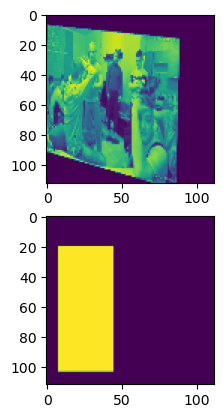

In [7]:
class RandomAffineVideoBboxes(v2.RandomAffine):
    def forward(self, video_tensor, bboxes_tensor):
        channels ,frames_num, rows, cols = video_tensor.shape
                
        params = self._get_params([video_tensor])

        video_tensor = v2.functional.affine(video_tensor, center=self.center, **params)
        for frame_idx in range(0, bboxes_tensor.size(0)):
            bbox = bboxes_tensor[frame_idx,0]
            #print(bbox.sum())
            if bbox.sum()>0:
                tv_bbox = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=(rows, cols))
                #print(tv_bbox)
                tv_bbox = v2.functional.affine(tv_bbox, center=self.center, **params)
                #print(tv_bbox)
                #print()
                bbox = tv_bbox.data
            bboxes_tensor[frame_idx, 0] = bbox

        return video_tensor, bboxes_tensor
    
class RandomPerspectiveVideoBboxes(v2.RandomPerspective):
    def forward(self, video_tensor, bboxes_tensor):
        channels ,frames_num, rows, cols = video_tensor.shape
                
        params = self._get_params([video_tensor])

        video_tensor = v2.functional.perspective(video_tensor, startpoints=None, endpoints=None, **params)
        for frame_idx in range(0, bboxes_tensor.size(0)):
            bbox = bboxes_tensor[frame_idx,0]
            #print(bbox.sum())
            if bbox.sum()>0:
                tv_bbox = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=(rows, cols))
                #print(tv_bbox)
                tv_bbox = v2.functional.perspective(tv_bbox, startpoints=None, endpoints=None, **params)
                #print(tv_bbox)
                #print()
                bbox = tv_bbox.data
            bboxes_tensor[frame_idx, 0] = bbox

        return video_tensor, bboxes_tensor
    
class RandomHorizontalFlipVideoBboxes(v2.RandomHorizontalFlip):
    def forward(self, video_tensor, bboxes_tensor):
        if torch.rand(1) >= self.p:
            return video_tensor, bboxes_tensor
        channels ,frames_num, rows, cols = video_tensor.shape
                
        video_tensor = v2.functional.horizontal_flip(video_tensor)
        for frame_idx in range(0, bboxes_tensor.size(0)):
            bbox = bboxes_tensor[frame_idx,0]
            #print(bbox.sum())
            if bbox.sum()>0:
                tv_bbox = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=(rows, cols))
                #print(tv_bbox)
                tv_bbox = v2.functional.horizontal_flip(tv_bbox)
                #print(tv_bbox)
                #print()
                bbox = tv_bbox.data
            bboxes_tensor[frame_idx, 0] = bbox

        return video_tensor, bboxes_tensor
    
class CreateBboxesMasks(nn.Module):
    def forward(self, video_tensor, bboxes):
        #print(bboxes.shape)
        channels, frames, rows, cols = video_tensor.shape
        canvas = np.zeros(shape=(frames, rows, cols), dtype=np.uint8)
        for frame_idx in range(min(bboxes.size(0), frames)):
            bbox = bboxes[frame_idx,0]
            #print(bbox.sum())
            if bbox.sum().item()>0:
                for b in bbox:
                    #frame = cv2.rectangle(canvas[frame_idx], pt1=tuple(b[:2]), pt2=tuple(b[2:]), color=(255,), thickness=-1)
                    pt1 = b[:2].tolist()
                    pt2 = b[2:].tolist()
                    try:
                        frame = cv2.rectangle(canvas[frame_idx], pt1, pt2, (255,), -1)
                    except:
                        print(f'bboxes {bboxes.shape}, canvas {canvas.shape}')
                canvas[frame_idx] = frame
            
        bbox_masks = torch.as_tensor(canvas, dtype=torch.float32).unsqueeze(0)
        return video_tensor, bbox_masks
    
class NormalizeBboxes(v2.Normalize):
    def forward(self, video_tensor, bboxes_tensor):
        video_tensor = super().forward(video_tensor.permute(1, 0, 2, 3))
        return video_tensor.permute(1, 0, 2, 3), bboxes_tensor

class ResizeBboxes(v2.Resize):
    def forward(self, video_tensor, bboxes_tensor):
        frames1, channels1, rows1, cols1 = video_tensor.shape
        frames1, channels1, rows2, cols2 = bboxes_tensor.shape
        video_tensor = super().forward(video_tensor)
        if rows1 == rows2 and cols1 == cols2:
            bboxes_tensor = super().forward(bboxes_tensor)
        else:
            for frame_idx in range(0, bboxes_tensor.size(0)):
                bbox = bboxes_tensor[frame_idx,0]
                #print(bbox.sum())
                if bbox.sum()>0:
                    tv_bbox = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=(rows1, cols1))
                    #print(tv_bbox)
                    tv_bbox = super().forward(tv_bbox)
                    #print(tv_bbox)
                    #print()
                    bbox = tv_bbox.data
                bboxes_tensor[frame_idx, 0] = bbox
        return video_tensor, bboxes_tensor
        
path_to_data = r'I:\AVABOS\DATASET_VERSION_1.0\phys\train\4LUoqxnyxlE(+)_._50.066-60.066!person,0!(0, 61)!Нет'
path_bo_video = os.path.join(path_to_data, 'video.mp4')
path_to_numpy = os.path.join(path_to_data, 'video.npy')
path_to_bboxes = os.path.join(path_to_data, 'bboxes.npy')
bboxes =  torch.as_tensor(np.load(path_to_bboxes))

print(bboxes.shape, frames.shape)
print()

#frames = np.load(path_to_numpy)
frames = read_video_frames_opencv(path_bo_video, 0, 32)
frames = torch.as_tensor(frames, dtype=torch.float32)
frames = frames.permute(3,0, 1, 2)
bboxes = bboxes[:32]
video_bboxes_affine = RandomAffineVideoBboxes(
    degrees = 4,
    translate = (0.2, 0.2),
    scale=(0.8, 1.2),
    shear=(-5, 5, -5, 5)
)

video_bboxes_perspective = RandomPerspectiveVideoBboxes(distortion_scale=0.2)

rand_hor_flip = RandomHorizontalFlipVideoBboxes(p=0.5)
transf = v2.Compose(
    [
        
        RandomPerspectiveVideoBboxes(distortion_scale=0.2),
        RandomAffineVideoBboxes(degrees = 4, translate = (0.2, 0.2), scale=(0.8, 1.2), shear=(-5, 5, -5, 5)),
        RandomHorizontalFlipVideoBboxes(p=0.5),
        CreateBboxesMasks(),
        NormalizeBboxes(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ResizeBboxes((112, 112)),
    ]
)
create_bbox_masks = CreateBboxesMasks()
#print(bboxes.shape, frames.shape)
frames, masks = transf(frames, bboxes)
#print(bboxes[0])
#frames, masks = create_bbox_masks(frames, bboxes)
fig, axs = plt.subplots(2, 1)
axs[0].imshow(frames[0][0])
#axs[1].imshow(frames[0][1])
axs[1].imshow(masks[0][0])
bboxes.shape

In [2]:
v2.Pad(padding=[])

<module 'torchvision.transforms.v2' from 'c:\\Users\\mokhail\\miniconda3\\envs\\aggr_rec\\lib\\site-packages\\torchvision\\transforms\\v2\\__init__.py'>

In [10]:
frames.shape

torch.Size([3, 32, 112, 112])

In [13]:
a, b = (1, 2, 3)

ValueError: too many values to unpack (expected 2)

In [221]:
frames.permute(1, 0, 2, 3).shape
frames[0][0].shape

torch.Size([360, 640])

In [ ]:
class RandomAffineVideoBboxes(v2.RandomAffine):
    def forwad(self, video_tensor, bboxes_tensor):
        affine_video = super().forward(video_tensor)

        frames_num = bboxes_tensor.size(0)

        for frame_idx in range(0, frames_num):
            if bboxes_tensor[:,frame_idx] == torch.long([[-1,-1,-1,-1]]):
                continue
            bboxes_tensor[:,frame_idx] = super().forward(bboxes_tensor[:,frame_idx])

        return affine_video, bboxes_tensor
    

video_bboxes_affine = RandomAffineVideoBboxes(
    degrees = 10,
    translate = (0.2, 0.2),
    scale=(0.8, 1.2),
    shear=(-10, 10, -10, 10)
)

video_tensor = torch.randn(3, 16, 244, 244)
torch.manual_seed(0)
bboxes = torch.randint(0, 244 // 2, size=(16, 1, 1, 4))
frames_num = bboxes.size(1)

bboxes[0] = torch.tensor([[[-1,-1,-1,-1]]])
#print(bboxes)

images_list = []
for frame_idx in range(0, frames_num):
    bbox = bboxes[frame_idx,0]
    if not bbox.sum()<0:
        bbox_tensor = tv_tensors.BoundingBoxes(bbox, format='XYXY', canvas_size=video_tensor.shape[-2:])
        bbox_tensor += 10
        bbox = bbox_tensor.data
        
    bboxes[frame_idx,0] = bbox
    #bboxes_tensor[:,frame_idx] = super().forward(bboxes_tensor[:,frame_idx])

# draw bboxes
channels, frames, rows, cols = video_tensor.shape
canvas = np.zeros(shape=(frames, rows, cols), dtype=np.uint8)
for frame_idx in range(bboxes.size(0)):
    bbox = bboxes[frame_idx,0]
    if bbox.sum()>0:
        #print(bbox)
        #bbox = torchvision.ops.box_convert(bbox, 'xyxy', 'xyxy')
        #print(bbox)
        #print()
        #frame = torchvision.utils.draw_bounding_boxes(canvas[:,frame_idx], bbox, labels=[0], colors=(255,255,255), fill=True, width=0)
        for b in bbox:
            #frame = cv2.rectangle(canvas[frame_idx], pt1=tuple(b[:2]), pt2=tuple(b[2:]), color=(255,), thickness=-1)
            pt1 = b[:2].tolist()
            pt2 = b[2:].tolist()
            frame = cv2.rectangle(canvas[frame_idx], pt1, pt2, (255,), -1)
        canvas[frame_idx] = frame
    
torch.as_tensor(canvas, dtype=torch.float32).unsqueeze(0)

canvas = torch.from_numpy(canvas).unsqueeze(0)
canvas* video_tensor

In [177]:
bboxes = torch.randint(0, 244 // 2, size=(16, 1, 1, 4))
frames_num = bboxes.size(0)

bboxes[0] = torch.tensor([[[-1,-1,-1,-1]]])
#print(bboxes)

images_list = []
for frame_idx in range(0, frames_num):
    bbox = bboxes[frame_idx,0]
    if not bbox.sum()<0:
        bbox_tensor = tv_tensors.BoundingBoxes(bboxes[frame_idx,0], format='XYXY', canvas_size=video_tensor.shape[-2:])
        bbox_tensor += 10
        bbox = bbox_tensor.data
        
    bboxes[frame_idx,0] = bbox

In [178]:
frames_num

1

In [ ]:
dir(v2.functional)
v2.functional.affine()

In [17]:
rows = 768
cols = 1024
frames = 32
video = torch.randn(1, 3, frames, rows, cols)
mask = torch.randn(1, 3, frames, rows, cols)

full_video_tensor = torch.cat([video, mask], dim=2)

resize = v2.Resize((112,112), antialias=True)

output = resize(full_video_tensor)
output.shape

video = output[:,:,:frames]
mask = output[:,:,frames:]

# костыль
mask = mask.mean(dim=1).unsqueeze(1)

print(mask.shape, video.shape)

alpha = 0.20

cnn3d = torchvision.models.video.r3d_18()
for name, module in cnn3d.named_children():
    print(name)
    if 'layer' in name or 'stem' in name:
        if mask.shape[2:] != video.shape[2:]:
            print('aaa')
            mask = nn.functional.interpolate(mask, video.shape[2:])
        masked_video = (1-alpha)*video + alpha*mask
        video = module(masked_video)
        print(video.shape)

torch.Size([1, 1, 32, 112, 112]) torch.Size([1, 3, 32, 112, 112])
stem
torch.Size([1, 64, 32, 56, 56])
layer1
aaa
torch.Size([1, 64, 32, 56, 56])
layer2
torch.Size([1, 128, 16, 28, 28])
layer3
aaa
torch.Size([1, 256, 8, 14, 14])
layer4
aaa
torch.Size([1, 512, 4, 7, 7])
avgpool
fc


In [46]:
mask.mean(dim=1).unsqueeze(1).shape

torch.Size([1, 1, 32, 56, 56])

In [ ]:
mask * torch.randn(1, 1, 32, 56, 56)

In [32]:
masked_video = video * mask
masked_video.shape

torch.Size([1, 3, 32, 112, 112])

In [21]:
r3d

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [27]:
class R3DWithBboxes(nn.Module):
    def __init__(self, class_num, alpha=0.4):
        super().__init__()
        self.alpha = alpha
        
        self.extractor = nn.ModuleDict()
        for name, module in torchvision.models.video.r3d_18().named_children():
            if 'layer' in name or 'stem' in name:
                self.extractor[name] = module
        self.output_classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, class_num)
        )

    def forward(self, data):
        frames, mask = data
        for name, module in self.extractor.items():
            if mask.shape[2:] != frames.shape[2:]:
                mask = nn.functional.interpolate(mask, frames.shape[2:])
            masked_frames = (1-self.alpha)*frames + self.alpha*mask
            frames = module(masked_frames)
        result = self.output_classifier(frames)

        return result
    
class R3D(R3DWithBboxes):
    def forward(self, frames):
        for name, module in self.extractor.items():
            frames = module(frames)
        result = self.output_classifier(frames)

        return result
aaa = torch.randn(8, 3, 32, 112, 112)
bbb = torch.randn(8, 1, 32, 112, 112)
cnn = R3DWithBboxes(4)
cnn((aaa, bbb)).shape

torch.Size([8, 4])

In [ ]:
r3d = torchvision.models.video.r3d_18(weights=torchvision.models.video.R3D_18_Weights.KINETICS400_V1)
s3d = torchvision.models.video.s3d(weights=torchvision.models.video.S3D_Weights.KINETICS400_V1)
s3d

In [18]:
class CNN3DWithBboxes(nn.Module):
    def __init__(self):
        super().__init__()
        self.initial_modules = torchvision.models.video.r3d_18()


cnn3d = torchvision.models.video.r3d_18()
video = torch.randn(1, 3, 32, 1024, 768)
mask = torch.randn(1, 3, 32, 1024, 768)
cnn3d(video)
for name, module in cnn3d.named_children():
    print(name)
    if 'layer' in name or 'stem' in name:
        
        video = module(video)
        print(video.shape)

stem
torch.Size([1, 64, 32, 112, 112])
layer1
torch.Size([1, 64, 32, 112, 112])
layer2
torch.Size([1, 128, 16, 56, 56])
layer3
torch.Size([1, 256, 8, 28, 28])
layer4
torch.Size([1, 512, 4, 14, 14])
avgpool
fc


# Print training log

In [16]:
import glob
import pandas as pd

paths_to_log_list = glob.glob(r'saving_dir\*R3D*\*.csv')

print('Maximum UAR values:')
for path in paths_to_log_list:
    if 'test_log' in path:
        model_name = os.path.split(path)[-1]
        model_name = model_name.split('_test_log')[0]
        df = pd.read_csv(path)
        max_val = df['UAR'].max()
        print(f'{model_name} UAR = {max_val}')


Maximum UAR values:
test_log_.csv UAR = 0.5642070353051418
test_log_.csv UAR = 0.5252455191040964
test_log_.csv UAR = 0.5266373299280668


In [18]:
df = pd.read_csv(r'saving_dir\25.10.2023, 19-44-34 (LSTM_1Layer)\test_log_.csv')
df['UAR'].max()

0.6396863602539251

In [17]:
paths_to_log_list

['saving_dir\\26.10.2023, 23-32-48 (R3D_avg)\\test_log_.csv',
 'saving_dir\\26.10.2023, 23-32-48 (R3D_avg)\\train_log_.csv',
 'saving_dir\\29.10.2023, 01-14-21 (R3D_avg)\\test_log_.csv',
 'saving_dir\\29.10.2023, 01-14-21 (R3D_avg)\\train_log_.csv',
 'saving_dir\\29.10.2023, 01-14-51 (R3D_avg)\\test_log_.csv',
 'saving_dir\\29.10.2023, 01-14-51 (R3D_avg)\\train_log_.csv']

# Test wav2vec jit model

In [8]:
wav2vec_extractor = torch.jit.load('wav2vec_feature_extractor_jit.pt')
wav2vec_extractor = wav2vec_extractor.cuda()
out = wav2vec_extractor(torch.randn(1, 160000).cuda()).permute(0, 2, 1)
out.shape

torch.Size([1, 998, 512])

# Prepare audio

In [38]:
lst = glob.glob(r'I:\AVABOS\trash_to_train_on_audio\*.wav')
os.makedirs(r'I:\AVABOS\audio_data\train',exist_ok=True)
os.makedirs(r'I:\AVABOS\audio_data\test',exist_ok=True)
with open('train_names.txt') as fd:
    train_names_list = [n[:-4] for n in fd.read().split('\n')]
target_sample_rate = 16000
target_time_length = 10
for path in tqdm(lst):
    name = os.path.split(path)[-1]
    waveform, sample_rate = torchaudio.load(path)
    #waveform = waveform[0].float()/65535
    waveform = torchaudio.functional.resample(waveform[0], sample_rate, target_sample_rate)
    if len(waveform)/target_time_length != target_sample_rate:
        target_samples = target_sample_rate*target_time_length - len(waveform)
        waveform = torch.cat([waveform, torch.zeros((target_samples,))])
    if name[:-4] in train_names_list:
        path_to_copy = os.path.join(r'I:\AVABOS\audio_data\train', name[:-4]+'.pt')
    else:
        path_to_copy = os.path.join(r'I:\AVABOS\audio_data\test', name[:-4]+'.pt')
    #torchaudio.save(path_to_copy, waveform, new_sample_rate, format='wav', bits_per_sample=16)
    #shutil.copy2(path, path_to_copy)
    torch.save(waveform, path_to_copy)

waveform

  0%|          | 0/2201 [00:00<?, ?it/s]

100%|██████████| 2201/2201 [00:50<00:00, 43.95it/s]


tensor([-0.1135, -0.1961, -0.1775,  ...,  0.0000,  0.0000,  0.0000])

In [36]:
waveform, sample_rate = torchaudio.load(path)
    #waveform = waveform[0].float()/65535
waveform = torchaudio.functional.resample(waveform[0], sample_rate, new_sample_rate)
waveform.shape

torch.Size([88992])

In [33]:
waveform, sample_rate = torchaudio.load(path)
print(waveform.dtype)
resampler = T.Resample(sample_rate, new_sample_rate, dtype=torch.int16)
resampler(waveform)


torch.float32


tensor([[ 0.3893,  0.5824,  0.3531,  ..., -0.0135, -0.0327, -0.0355],
        [ 0.3893,  0.5824,  0.3531,  ..., -0.0135, -0.0327, -0.0355]])

In [24]:
torchaudio.save('aaa.wav', waveform, sample_rate, bits_per_sample=16)

In [15]:
shutil.rmtree(r'C:\Users\mokhail\python_programming\MultimodalAggressionRecognition\saving_dir\30.10.2023, 01-04-46 (wav2vec2)')

# Проверка экстрактора аудио

In [9]:
class AudioDataset(torch.utils.data.Dataset):
    label_dict = {'AGGR': 1, 'NOAGGR': 0}
    def __init__(self, path_to_data_root, target_sample_rate, target_time_length, device):
        super().__init__()
        self.path_to_data_root = path_to_data_root
        self.target_sample_rate = target_sample_rate
        self.target_time_length = target_time_length
        self.device = device
        self.data_names_list = [n for n in os.listdir(path_to_data_root) if n.endswith('.wav')]

    def get_label(self, idx):
        #A structure of a file name is xxx_._yyy_._LABEL.npy
        #name = os.path.split(self.paths_to_data_list[idx])[-1]
        name = self.data_names_list[idx]
        return self.label_dict[name.split('_._')[-1].split('.')[0]]

    def read_data_file(self, idx):
        #name = self.files_list[idx]
        #path_to_data_file = os.path.join(self.path_to_data_files, name)
        name = self.data_names_list[idx]
        path_to_data = os.path.join(self.path_to_data_root, name)
        #data = torch.as_tensor(np.load(path_to_data), dtype=torch.float32)
        waveform, sample_rate = torchaudio.load(path_to_data)
        #waveform = waveform[0].to('cuda')
        if sample_rate != self.target_sample_rate:
            data = torchaudio.functional.resample(waveform[0].to(self.device), sample_rate, self.target_sample_rate)
        #data = torch.as_tensor(np.load(self.paths_to_data_list[idx]), dtype=torch.float32)
        #tv_data = tv_tensors.Video(data, device=self.device)
        if len(data)/self.target_time_length != self.target_sample_rate:
            target_samples = self.target_sample_rate*self.target_time_length - len(data)
            data = torch.cat([data, torch.zeros((target_samples,)).to(self.device)])
            
        return data#[0]
    
    def __len__(self):
        return len(self.data_names_list)
    
    def __getitem__(self, idx):
        data = self.read_data_file(idx)
        label = self.get_label(idx)
        return data, label
    

class LossesDict(dict):
    def backward(self):
        for name, loss in self.items():
            loss.backward()


class AverageFeatureSequence(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        #self.input_size = input_size
        #self.fc_projection = nn.Sequential(nn.Linear(input_size, hidden_size))

    def forward(self, x):
        return x.mean(dim=1).unsqueeze(1), None


class MultiCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output_dict, target):
        losses_dict = LossesDict()
        for name, preds in output_dict.items():
            losses_dict[name] = self.criterion(preds, target)

        return losses_dict


class AudioMultiNN(nn.Module):
    def __init__(self, models_dict, extractor_dict):
        super().__init__()
        self.extractor_dict = nn.ModuleDict(extractor_dict)
        self.extractor_dict.eval()

        #for name, model in rnn_dict.items():
        #    rnn_dict[name] = model['model'](**model['kwargs'])

        self.models_dict = nn.ModuleDict(models_dict)

    def get_models_names(self):
        return [extractor_name for extractor_name in self.extractor_dict.keys()], [name for name in self.models_dict.keys()]

    def forward(self, x):
        with torch.no_grad():
            for name, model in self.extractor_dict.items():
                features, _ = model.extract_features(x)
            #features, _ = self.extractor.extract_features(x)

        #return features
        output_dict = {}
        for name, model in self.models_dict.items():
            output_dict[name] = model(features[-1]) 
        return output_dict
    
class VideoMultiNN(nn.Module):
    def __init__(self, rnn_dict, extractor_dict):
        super().__init__()
        self.extractor_dict = nn.ModuleDict(extractor_dict)
        self.extractor_dict.eval()

        #for name, model in rnn_dict.items():
        #    rnn_dict[name] = model['model'](**model['kwargs'])

        self.models_dict = nn.ModuleDict(rnn_dict)

    def get_models_names(self):
        return [extractor_name for extractor_name in self.extractor_dict.keys()], [name for name in self.models_dict.keys()]

    def forward(self, x):
        with torch.no_grad():
            for name, model in self.extractor_dict.items():
                features, _ = model.extract_features(x)
            #features, _ = self.extractor.extract_features(x)

        #return features
        output_dict = {}
        for name, model in self.models_dict.items():
            output_dict[name] = model(features[-1]) 
        return output_dict
    
class FeatureSequenceProcessing(nn.Module):
    def __init__(self, sequence_nn_dict, class_num):
        super().__init__()
        self.sequence_nn = sequence_nn_dict['model'](**sequence_nn_dict['kwargs'])
        self.hidden_size = sequence_nn_dict['kwargs']['hidden_size']

        # The linear layer that maps from hidden state space to tag space
        self.output_classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, class_num)
        )

    def forward(self, sequence):
        sequence, _ = self.sequence_nn(sequence)
        preds = self.output_classifier(sequence[:,-1,:])
        return preds

    
rnn_dict = {
    'LSTM_1L': {
        'model': nn.LSTM,
        'kwargs': {
            'input_size':768,
            'hidden_size':512,
            'num_layers':1,
            'bias':True,
            'batch_first':True,
            'dropout':0,
            'bidirectional':False,
            'proj_size':0
        }
    },
    'GRU_1L': {
        'model': nn.GRU,
        'kwargs': {
            'input_size':768,
            'hidden_size':512,
            'num_layers':1,
            'bias':True,
            'batch_first':True,
            'dropout':0,
            'bidirectional':False
        }
    },
    'LSTM_2L_drop': {
        'model': nn.LSTM,
        'kwargs': {
            'input_size':768,
            'hidden_size':512,
            'num_layers':2,
            'bias':True,
            'batch_first':True,
            'dropout':0.3,
            'bidirectional':False,
            'proj_size':0
        }
    },
    'GRU_2L_drop': {
        'model': nn.GRU,
        'kwargs': {
            'input_size':768,
            'hidden_size':512,
            'num_layers':2,
            'bias':True,
            'batch_first':True,
            'dropout':0.3,
            'bidirectional':False
        }
    },
    'Avg_features': {
        'model': AverageFeatureSequence,
        'kwargs': {'hidden_size':768}
    }
}

input_size = 768 # определяется размером вектора признаков, получаемого с экстрактора
hidden_size = 512 # не будет работать, если будет более двух слоев rnn
rnn_dict = {
    'LSTM_1L': {
        'model': nn.LSTM,
        'kwargs': {
            'input_size':input_size,
            'hidden_size':hidden_size,
            'num_layers':1,
            'bias':True,
            'batch_first':True,
            'dropout':0,
            'bidirectional':False,
            'proj_size':0
        }
    },
    'GRU_1L': {
        'model': nn.GRU,
        'kwargs': {
            'input_size':input_size,
            'hidden_size':hidden_size,
            'num_layers':1,
            'bias':True,
            'batch_first':True,
            'dropout':0,
            'bidirectional':False
        }
    },
    'Avg_features': {
        'model': AverageFeatureSequence,
        'kwargs': {'hidden_size':input_size}
    }
}
models_dict = {}
for name, model in rnn_dict.items():
    models_dict[name] = FeatureSequenceProcessing(model, class_num=2)

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
extractor_dict = {
    'Wav2Vec2': bundle.get_model()
}

net = AudioMultiNN(models_dict=models_dict, extractor_dict=extractor_dict)
net.train()

opt = torch.optim.Adam(net.parameters())
criterion = MultiCrossEntropyLoss()

opt.zero_grad()
pred = net(torch.randn(8, 160000))

targets = torch.randint(0, 2, size=(8,))
loss = criterion(pred, targets)
loss.backward()
opt.step()

net.get_models_names()

(['Wav2Vec2'], ['LSTM_1L', 'GRU_1L', 'Avg_features'])

In [21]:
class FeatureSequenceProcessing(nn.Module):
    def __init__(self, sequence_nn_dict, class_num):
        super().__init__()
        self.sequence_nn = sequence_nn_dict['model'](**sequence_nn_dict['kwargs'])
        self.hidden_size = sequence_nn_dict['kwargs']['hidden_size']

        # The linear layer that maps from hidden state space to tag space
        self.output_classifier = nn.Sequential(
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, class_num)
        )

    def forward(self, sequence):
        sequence, _ = self.sequence_nn(sequence)
        return sequence
        preds = self.output_classifier(sequence[:,-1,:])
        return preds

    
rnn_dict = {
    'model': nn.LSTM,
        'kwargs': {
            'input_size':768,
            'hidden_size':512,
            'num_layers':2,
            'bias':True,
            'batch_first':True,
            'dropout':0.3,
            'bidirectional':False,
            'proj_size':0
        }
}



rnn = FeatureSequenceProcessing(rnn_dict, class_num=2)
sequence = torch.randn(1, 400, 768)
a = rnn(sequence)
#len(a)
a.shape

torch.Size([1, 400, 512])

In [26]:
a = torch.randn(1, 10)
a.unsqueeze(1)[:,-1,:].shape

torch.Size([1, 10])

In [ ]:


################################################

batch_size = 32
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

audio_data = AudioDataset(r'I:\AVABOS\trash_to_train_on_audio', bundle.sample_rate, 10, 'cpu')

audio_dataloader = torch.utils.data.DataLoader(audio_data, batch_size=batch_size, shuffle=True)

extractor = bundle.get_model().to('cuda')
extractor.eval()

rnn = RNN(
    rnn_type=nn.LSTM,
    rnn_layers_num=1,
    input_dim=768,
    hidden_dim=512,
    class_num=2
).to('cuda')


opt = torch.optim.Adam(rnn.parameters())
criterion = MultiCrossEntropyLoss()

rnn.train()

times = []
#for i in tqdm(range(len(audio_data))):
#    d, l = audio_data[i]
#    times.append(len(d))
#np.mean(times)
extracted_list = []
t0 = time.time()
for data, targets in tqdm(audio_dataloader):
    data, targets = data.to('cuda'), targets.to('cuda')
    
    with torch.no_grad():
        features, _ = extractor.extract_features(data)
    
    #features = features[-1]
    
    opt.zero_grad()
    pred = rnn(features[-1])
    loss = criterion(pred, targets)
    loss.backward()
    opt.step()
    

    #extracted_list.append([data, targets])
'''
for data, targets in tqdm(extracted_list):
    opt.zero_grad()
    pred = rnn(data)
    loss = criterion(pred, targets)
    loss.backward()
    opt.step()
'''
t1 = time.time()
print(t1-t0)

In [6]:
features.shape

torch.Size([32, 499, 768])

In [55]:
f = features[-1].cpu()
size = f.__sizeof__()+torch.numel(f)*f.element_size()
size/1024/1024*2201

3217.8071899414062

In [ ]:
137

In [4]:
features.shape


torch.Size([64, 499, 768])

In [4]:
class LossesDict(dict):
    def backward(self):
        for name, loss in self.items():
            loss.backward()

class AudioMultiRNN(nn.Module):
    def __init__(self, rnn_dict):
        super().__init__()
        #self.exractor = extractor
        for name, model in rnn_dict.items():
            rnn_dict[name] = model['model'](**model['kwargs'])
        self.models_dict = nn.ModuleDict(rnn_dict)

    def forward(self, x):
        output_dict = {}
        for name, model in self.models_dict.items():
            output_dict['model_name'] = model(x) 
        return output_dict


class MultiCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output_dict, target):
        losses_dict = LossesDict()
        for name, preds in output_dict.items():
            losses_dict[name] = self.criterion(preds, target)

        return losses_dict
        

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
path_to_audio = r'I:\AVABOS\trash_to_train_on_audio\2g7X7-D6HYY(+)_._0.066-10.066_._AGGR.wav'
name = os.path.split(path_to_audio)[-1][:-4]
extractor = bundle.get_model().to('cuda')

waveform, sample_rate = torchaudio.load(path_to_audio)
#waveform = waveform[0].to('cuda')
waveform.shape

Audio(waveform.numpy()[0], rate=sample_rate)

In [6]:
paths_to_wavs = glob.glob(r'I:\AVABOS\trash_to_train_on_audio\*.wav')
times = []
for path in tqdm(paths_to_wavs):
    waveform, sample_rate = torchaudio.load(path_to_audio)
    times.append(len(waveform[0])/sample_rate)

np.mean(times)

  0%|          | 0/2201 [00:00<?, ?it/s]

100%|██████████| 2201/2201 [00:30<00:00, 71.25it/s]


10.0

In [ ]:
md = nn.ModuleDict({'Linear1': nn.Linear(14, 88), 'Linear2': nn.Linear(14, 88)})
x = torch.randn(1, 14)
result_dict = {}
for model_name, model in md.items():
    result_dict[model_name] = model(x)
    print(model_name, model)

result_dict

In [50]:
class listed_losses(list):
    '''
    A list inhereted class with backward method in order to fulfil bakward method for multiple independed losses
    '''
    def backward(self):
        for loss in self:
            loss.backward()

class LossesDict(dict):
    def backward(self):
        for name, loss in self.items():
            loss.backward()

class MultiCrossEntropy(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, output_list, target):
        losses_list = listed_losses()
        for preds in output_list:
            losses_list.append(self.criterion(preds, target))
        
        return losses_list

class MultipleModels(nn.Module):
    def __init__(self, input_size, class_num):
        super().__init__()
        self.model1 = nn.Linear(input_size, class_num)
        self.model2 = nn.Linear(input_size, class_num)

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return [out1, out2]


batch_size = 1
input_size = 8
class_num = 2
criterion = nn.CrossEntropyLoss()

'''
model1 = nn.Sequential(
    nn.Linear(input_size, 32),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(32, class_num)
)

model2 = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64, class_num)
)
'''
#model1 = nn.Linear(input_size, class_num)
#model2 = nn.Linear(input_size, class_num)

multimodel = MultipleModels(input_size, class_num)

criterion = MultiCrossEntropy()

opt = torch.optim.SGD(multimodel.parameters(), lr=1.0)

print(multimodel.model1.weight.grad)
print(multimodel.model2.weight.grad)
print(multimodel.model1.weight)
print(multimodel.model2.weight)
print('------------------------------------------------------------------')

#opt.zero_grad()
#preds1 = model1(torch.randn(batch_size, input_size))
#preds2 = model2(torch.randn(batch_size, input_size))
preds_list = multimodel(torch.randn(batch_size, input_size))
targets = torch.randint(0, class_num, (batch_size,))
#targets = torch.ones((batch_size,), dtype=torch.int64)

loss = criterion(preds_list, targets)

#loss1.backward()

loss.backward()
opt.step()

print('GRAD')
print(multimodel.model1.weight.grad)
print(multimodel.model2.weight.grad)
print('UPDATED')
print(multimodel.model1.weight)
print(multimodel.model2.weight)

None
None
Parameter containing:
tensor([[ 0.3018, -0.1427,  0.1946,  0.0196, -0.3357,  0.0078,  0.1839, -0.2202],
        [ 0.1528,  0.3240,  0.1431,  0.3212, -0.3368,  0.1228,  0.2595, -0.2508]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1018, -0.1421,  0.1646,  0.0189, -0.1594,  0.1400, -0.0532, -0.1909],
        [ 0.0518, -0.1793,  0.2845,  0.2397,  0.2808,  0.1928, -0.2210, -0.0785]],
       requires_grad=True)
------------------------------------------------------------------
GRAD
tensor([[ 0.3226,  0.3669, -0.0777, -0.2348,  0.0800, -0.3232,  0.3286, -0.4281],
        [-0.3226, -0.3669,  0.0777,  0.2348, -0.0800,  0.3232, -0.3286,  0.4281]])
tensor([[ 0.3859,  0.4388, -0.0929, -0.2809,  0.0957, -0.3866,  0.3931, -0.5121],
        [-0.3859, -0.4388,  0.0929,  0.2809, -0.0957,  0.3866, -0.3931,  0.5121]])
UPDATED
Parameter containing:
tensor([[-0.0208, -0.5095,  0.2723,  0.2545, -0.4157,  0.3310, -0.1447,  0.2079],
        [ 0.4755,  0.6909,  0.0654,  0.0864, -0.

In [39]:
model1.weight.grad

tensor([[ 0.5884,  0.5340,  0.0130, -0.1871,  0.0452,  0.6197, -1.2483,  0.1557],
        [-0.5884, -0.5340, -0.0130,  0.1871, -0.0452, -0.6197,  1.2483, -0.1557]])

In [8]:
class listed_losses(list):
    def backward(self):
        for loss in self:
            loss.backward()
            

lst = inherit_list([1, 2, 3])
dir(lst)
lst.backward()

1
2
3


In [32]:
x = torch.randn(1, 3, 8)
torch.cat([x, x, x], 0).shape

torch.Size([3, 3, 8])

In [21]:
for idx, f in enumerate(features):
    print(idx, f.shape)


0 torch.Size([1, 499, 768])
1 torch.Size([1, 499, 768])
2 torch.Size([1, 499, 768])
3 torch.Size([1, 499, 768])
4 torch.Size([1, 499, 768])
5 torch.Size([1, 499, 768])
6 torch.Size([1, 499, 768])
7 torch.Size([1, 499, 768])
8 torch.Size([1, 499, 768])
9 torch.Size([1, 499, 768])
10 torch.Size([1, 499, 768])
11 torch.Size([1, 499, 768])


In [9]:
np.random.seed(1)
true = np.random.randint(0,2, size=50)
pred = np.random.randint(0,2, size=50)

print(metrics.recall_score(true, pred, average='binary'))
print(metrics.recall_score(true, pred, average='macro'))
print(metrics.recall_score(true, pred, average='micro'))
print(metrics.recall_score(true, pred, average=None))

0.6296296296296297
0.5756843800322061
0.58
[0.52173913 0.62962963]


# ВИДЕО

In [ ]:
class VideoAverageFeatures(nn.Module):
    def __init__(self, input_dim, class_num):
        super().__init__()
        self.output_classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, class_num)
        )

    def forward(self, x):
        return self.output_classifier(x.mean(dim=1))

In [13]:
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 4, 1, 2, 3)
    
model = torchvision.models.video.s3d().cuda()
model = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()#, Permute(), nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()
size = (1, 3, 16, 112, 112)
model.eval()
out = model(torch.randn(*size).cuda())

times = []
for i in range(100):
    t0 = time.time()
    with torch.inference_mode():
        out = model(torch.randn(*size).cuda())
    times.append(time.time()-t0)

print(np.mean(times), out.shape)

0.022308921813964842 torch.Size([1, 1024])


In [ ]:
model

In [3]:
size = (1, 3, 16, 224, 224)
model = torchvision.models.video.s3d()
model = nn.Sequential(*list(model.children())[:-2], Permute()).cuda()#, Permute(), nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()
out = model(torch.randn(*size).cuda())
out.shape

NameError: name 'Permute' is not defined

In [2]:
def read_video_frames_opencv(path_to_video):
    cap = cv2.VideoCapture(path_to_video)
    frames_list = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames_list.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #return torch.tensor(np.array(frames_list).transpose(0, 3, 1, 2))
    #return tv_tensors.Video(np.array(frames_list).transpose(0, 3, 1, 2))
    return np.array(frames_list)#)#.transpose(0, 3, 1, 2)

In [7]:
model = None

In [32]:
model = torchvision.models.video.mvit.mvit_v1_b().cuda()
model = nn.Sequential(*list(model.children())[:-2])#,nn.Flatten())
class MViT_extractor(torchvision.models.video.mvit.MViT):
    def forward(self, x):
        # Convert if necessary (B, C, H, W) -> (B, C, 1, H, W)
        x = _unsqueeze(x, 5, 2)[0]
        # patchify and reshape: (B, C, T, H, W) -> (B, embed_channels[0], T', H', W') -> (B, THW', embed_channels[0])
        x = self.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)

        # add positional encoding
        x = self.pos_encoding(x)

        # pass patches through the encoder
        thw = (self.pos_encoding.temporal_size,) + self.pos_encoding.spatial_size
        for block in self.blocks:
            x, thw = block(x, thw)
        x = self.norm(x)

        # classifier "token" as used by standard language architectures
        return x[:, 0]


Sequential(
  (0): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
  (1): PositionalEncoding()
  (2): ModuleList(
    (0): MultiscaleBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MultiscaleAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (project): Sequential(
          (0): Linear(in_features=96, out_features=96, bias=True)
        )
        (pool_k): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          )
        )
        (pool_v): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elem

In [2]:
model = torchvision.models.video.r3d_18()
model = nn.Sequential(*list(model.children())[:-1])#,nn.Flatten())
out = model(torch.randn(1, 3, 16, 112, 112))

out.shape
#model

torch.Size([1, 512, 2, 7, 7])

In [ ]:
torchvision.models.video.s3d()

In [ ]:
list(torchvision.models.video.s3d().children())[0]

In [71]:
cap = cv2.VideoCapture(path_to_video)
#cap.get(cv2.CAP_PROP_FRAME_COUNT)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    print(frame.shape)
cap.release()

In [67]:
frames = read_video_frames_opencv(path_to_video)
frames

[]

In [3]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')
paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')
paths_to_audios_list[0], paths_to_videos_list[0]

('C:\\Users\\admin\\python_programming\\DATA\\AVABOS\\trash_to_train_on_audio\\-kpsb88q2ac(+)_._0.066-10.066_._NOAGGR.wav',
 'C:\\Users\\admin\\python_programming\\DATA\\AVABOS\\trash_to_train_on_video\\-kpsb88q2ac(+)_._0.066-10.066_._NOAGGR.mp4')

In [26]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames.shape

(301, 270, 480, 3)

In [27]:
frames = torch.as_tensor(frames.transpose(0, 3, 1, 2))
frames.shape

torch.Size([301, 3, 270, 480])

In [28]:
tv_frames = tv_tensors.Video(frames)

In [29]:
resizer = v2.Resize(size=(224, 224), antialias=True)
tv_frames = resizer(tv_frames)
tv_frames.shape, frames.shape

(torch.Size([301, 3, 224, 224]), torch.Size([301, 3, 270, 480]))

In [ ]:
plt.imshow(tv_frames.numpy().transpose(0, 2, 3, 1)[0])

In [ ]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames = torch.as_tensor(frames.transpose(0, 3, 1, 2))
print(frames.shape)
tv_frames = tv_tensors.Video(frames)
print(tv_frames.shape)
resizer = v2.Resize(size=(224, 224), antialias=True)
tv_frames = resizer(tv_frames)
print(tv_frames.shape)
frames = tv_frames.numpy().transpose(0, 2, 3, 1)
plt.imshow(frames[0])

  0%|          | 0/2201 [00:00<?, ?it/s]

100%|██████████| 2201/2201 [32:23<00:00,  1.13it/s]


(array([   7.,    7.,    7.,    4.,   11.,    7.,  155.,    5.,  362.,
        1636.]),
 array([  0. ,  30.1,  60.2,  90.3, 120.4, 150.5, 180.6, 210.7, 240.8,
        270.9, 301. ]),
 <BarContainer object of 10 artists>)

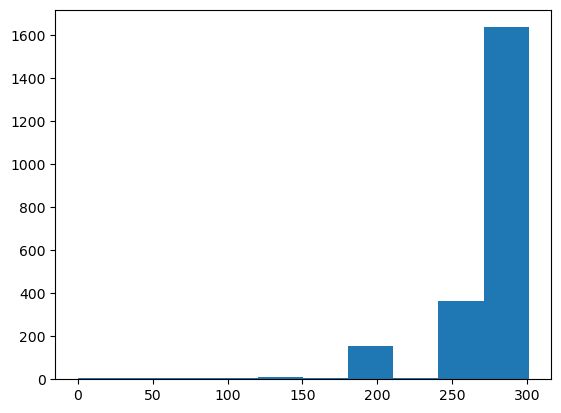

In [74]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')

video_lengths_list = []

for path_to_video in tqdm(paths_to_videos_list):
    
    name = os.path.split(path_to_video)[1][:-4]
    path_to_save_numpy = os.path.join(path_to_numpy, name+'.npy')

    frames = read_video_frames_opencv(path_to_video)
    
    frame_num = len(frames)
    video_lengths_list.append(frame_num)

plt.hist(video_lengths_list)

# Превращаем видео в Numpy array, для ускорения обработки

In [ ]:
paths_to_videos_list = glob.glob(r'I:\AVABOS\trash_to_train_on_video\*.mp4')
#paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')

path_to_numpy = r'I:\AVABOS\trash_to_train_on_video_numpy'
os.makedirs(path_to_numpy, exist_ok=True)

video_lengths_list = []

frame_cut_idx = 304 # 16*19

for path_to_video in tqdm(paths_to_videos_list):
    
    name = os.path.split(path_to_video)[1][:-4]
    path_to_save_numpy = os.path.join(path_to_numpy, name + '.npy')

    frames = read_video_frames_opencv(path_to_video)
    
    frame_num = len(frames)
    video_lengths_list.append(frame_num)

    if frame_num == 0:
        continue
    
    if frame_num > frame_cut_idx:
        frames = frames[:frame_cut_idx]
    elif frame_num < frame_cut_idx:
        pad_value = frame_cut_idx - frame_num
        rows = frames.shape[1]
        cols = frames.shape[2]
        channels = frames.shape[3]
        canvas = np.zeros(shape=(frame_cut_idx, rows, cols, channels), dtype=frames.dtype)
        canvas[:frame_num] = frames
        frames = canvas

    frames = frames.transpose(0, 3, 1, 2)

    frames = torch.as_tensor(frames)
    #print(frames.shape)
    tv_frames = tv_tensors.Video(frames)
    #print(tv_frames.shape)
    resizer = v2.Resize(size=(112, 112), antialias=True)
    tv_frames = resizer(tv_frames)
    #print(tv_frames.shape)
    frames = tv_frames.numpy()#.transpose(0, 2, 3, 1)

    np.save(path_to_save_numpy, frames)
    

np.load(path_to_save_numpy).shape, video_lengths_list



In [9]:
paths_to_videos_list = glob.glob(r'I:\AVABOS\trash_to_train_on_video_numpy\*.npy')

train, test = model_selection.train_test_split(paths_to_videos_list, test_size=0.3, random_state=1)
#with open('file_names.txt', 'w') as fd:
indices = [1, 3, 55, 123, 44, 77, 100, 256, 455, 326, 431]

train_names = [os.path.split(p)[-1] for p in train]

with open('train_names.txt', 'w', encoding='utf-8') as fd:
    fd.write('\n'.join(train_names))

with open('train_names.txt', 'r') as fd:
    train_names = fd.read()

train_names = train_names.split('\n')

['DQmiOwaeb5Y(+)_._490.066-500.066_._AGGR.npy',
 'dV6sZNvEFSk(+)_._120.066-130.066_._AGGR.npy',
 '31V2f1CRoX0(+)_._100.066-110.066_._AGGR.npy',
 'ZPK9sLzIjcQ(+)_._10.066-20.066_._NOAGGR.npy',
 'bXEQu52HOKw(+)_._220.066-230.066_._NOAGGR.npy',
 'vU1wiRudB50(+)_._230.066-240.066_._NOAGGR.npy',
 'oFLvI2MmkK0(+)_._30.066-40.066_._NOAGGR.npy',
 '4LUoqxnyxlE(+)_._350.066-360.066_._NOAGGR.npy',
 'hZWn9Nfp6mA(+)_._590.066-600.066_._NOAGGR.npy',
 '4LUoqxnyxlE(+)_._540.066-544.744_._NOAGGR.npy',
 'dg84dhgBmw0(+)_._550.066-560.066_._NOAGGR.npy',
 'qXwYhsoQj34(+)_._210.066-220.066_._AGGR.npy',
 '8zU8uX1XCcE(+)_._330.066-340.066_._AGGR.npy',
 'SgXMh2H0qBU(+)_._170.066-180.066_._NOAGGR.npy',
 'mHOd2VUSCvo(+)_._700.066-710.066_._NOAGGR.npy',
 'EqWiWHAR-j0(+)_._490.066-500.066_._AGGR.npy',
 'fOzMA5D4KUc(+)_._470.066-480.066_._NOAGGR.npy',
 'dg84dhgBmw0(+)_._410.066-420.066_._AGGR.npy',
 'mHOd2VUSCvo(+)_._570.066-580.066_._AGGR.npy',
 'dg84dhgBmw0(+)_._100.066-110.066_._NOAGGR.npy',
 'RUQ4mTzUk4w(+)_._6

In [ ]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')

train, test = model_selection.train_test_split(paths_to_videos_list, test_size=0.3, random_state=1)
#with open('file_names.txt', 'w') as fd:
indices = [1, 3, 55, 123, 44, 77, 100, 256, 455, 326, 431]

for idx in indices:
    print(paths_to_videos_list[idx])

In [16]:
npy_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')
idx = 35
npy_times = []
for i in range(100):
    t0 = time.time()
    frames = np.load(npy_list[idx])
    npy_times.append(time.time()-t0)

print(np.mean(npy_times))

name = os.path.split(npy_list[idx])[1][:-4] + '.mp4'
path_to_video = os.path.join(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video', name)
frames_times = []
for i in range(100):
    t0 = time.time()
    frames = read_video_frames_opencv(path_to_video)
    frames_times.append(time.time()-t0)

print(np.mean(frames_times))

0.02744727611541748
0.3672028565406799


In [ ]:
npy_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')
for path in tqdm(npy_list):
    frames = np.load(path)

[301, 301]

In [58]:
np.mean(video_lengths_list)

279.82884310618067

(array([  1.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   1.,
          4.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,
         65.,   2.,   1.,   0.,   1.,   0.,  65.,   0., 157.,   0.,  24.,
          0.,  24.,   1.,  64.,  17., 815.]),
 array([  8.  ,  13.86,  19.72,  25.58,  31.44,  37.3 ,  43.16,  49.02,
         54.88,  60.74,  66.6 ,  72.46,  78.32,  84.18,  90.04,  95.9 ,
        101.76, 107.62, 113.48, 119.34, 125.2 , 131.06, 136.92, 142.78,
        148.64, 154.5 , 160.36, 166.22, 172.08, 177.94, 183.8 , 189.66,
        195.52, 201.38, 207.24, 213.1 , 218.96, 224.82, 230.68, 236.54,
        242.4 , 248.26, 254.12, 259.98, 265.84, 271.7 , 277.56, 283.42,
        289.28, 295.14, 301.  ]),
 <BarContainer object of 50 artists>)

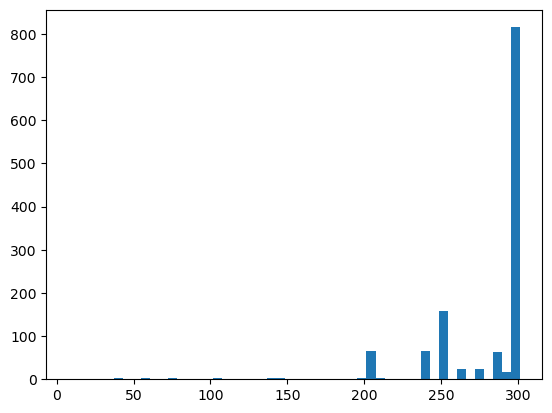

In [72]:
plt.hist(video_lengths_list, bins=50)

In [5]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')
paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')
times = []

# test execution time
for i in range(100):
    t0 = time.time()
    #a, b, c, = torchvision.io.read_video(paths_to_videos_list[0])
    frames = read_video_frames_opencv(paths_to_videos_list[0])
    audio = scipy.io.wavfile.read(paths_to_audios_list[0])
    audio = torch.tensor(audio[1])
    times.append(time.time()-t0)

np.mean(times)


0.2548658323287964

In [ ]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames

torch.Size([301, 3, 270, 480])
torch.Size([301, 3, 270, 480])


TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


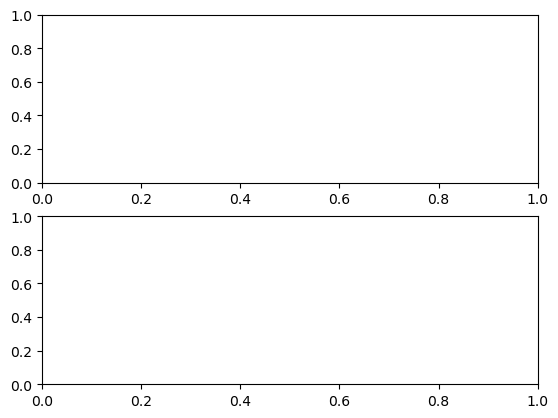

In [50]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
resizer = v2.Resize(size=(224, 224), antialias=True) 
print(frames.shape)

resized_frames = resizer(frames)

print(frames.shape)
fig, axs = plt.subplots(2, 1)

# numpy
#axs[0].imshow(frames[0].transpose(1,2,0))
#axs[1].imshow(resized_frames.transpose(1,2,0))

# pytorch
axs[0].imshow(frames[0].transpose(1,2,0))
axs[1].imshow(resized_frames.transpose(1,2,0))

#plt.imshow(frames[0])

In [51]:
frames[0].transpose(1, 2, 0)

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [48]:
transforms = v2.Compose([
    #v2.ToTensor(),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=20, translate=(0.7, 1.1), scale=(0.6, 1.1), shear=10),
    v2.RandomPesrspective(distortion_scale=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformed = transforms(frames)

transformed

array([[[[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        [[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        [[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        ...,

        [[134, 143, 149],
         [181, 190, 196],
         [170, 179, 185],
         ...,
         [ 65,  55,  70],
         [ 73,  60,  76],
         [ 74,  61,  77]],

        [[118, 127, 133],
         [136, 145, 151],
         [133, 142, 148],
         ...,
         [ 65,  55,  70],
         [ 68,  55,  71],
         [ 73,  60,  76]],

        [[105, 114, 120],
         [125, 134, 140],
         [120, 129, 135],
         ...,
         [ 63,  53,  68],
        